In [7]:
import tensorflow as tf
from zipfile import ZipFile
import os,glob
import cv2
from tqdm.notebook import tqdm_notebook as tqdm
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Convolution2D, Dropout, Dense,MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [8]:
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json 
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection

Saving kaggle.json to kaggle.json
 79% 12.0M/15.1M [00:00<00:00, 121MB/s]
100% 15.1M/15.1M [00:00<00:00, 134MB/s]


In [9]:
from zipfile import ZipFile
file_name = "/content/brain-mri-images-for-brain-tumor-detection.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [10]:
os.chdir('/content/yes')
X = []
y = []
for i in tqdm(os.listdir()):
      img = cv2.imread(i)   
      img = cv2.resize(img,(256,256))
      X.append(img)
      y.append(1)
os.chdir('/content/no')
for i in tqdm(os.listdir()):
      img = cv2.imread(i)   
      img = cv2.resize(img,(256,256))
      X.append(img)
      y.append(0)

  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

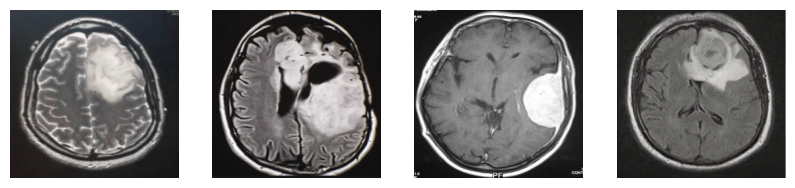

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(X[i], cmap="gray")
    plt.axis('off')
plt.show()

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print ("Shape of an image in X_train: ", X_train[0].shape)
print ("Shape of an image in X_test: ", X_test[0].shape)

Shape of an image in X_train:  (256, 256, 3)
Shape of an image in X_test:  (256, 256, 3)


In [13]:
y_train = np.array(y_train)
X_train = np.array(X_train)
y_test = np.array(y_test)
X_test = np.array(X_test)
print("X_train Shape: ", X_train.shape) 
print("X_test Shape: ", X_test.shape) 
print("y_train Shape: ", y_train.shape) 
print("y_test Shape: ", y_test.shape)

X_train Shape:  (169, 256, 256, 3)
X_test Shape:  (84, 256, 256, 3)
y_train Shape:  (169,)
y_test Shape:  (84,)


In [25]:
class QLearning:
    def __init__(self, state_shape, action_size, alpha=0.1, gamma=0.99, epsilon=1.0, epsilon_decay=0.001, epsilon_min=0.01):
        self.state_shape = state_shape
        self.action_size = action_size
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.Q = np.zeros((np.prod(self.state_shape), self.action_size))
        

    def get_action(self, state):
         if np.random.uniform(0,1) < self.epsilon:
            return np.random.randint(self.action_size)
         else:
           state_flat = np.ravel(state)
           return np.argmax(self.Q[state_flat, :])

    def update_q_table(self, state, action, reward, next_state):
        state_flat = state
        next_state_flat = next_state
        td_target = reward + self.gamma * np.max(self.Q[next_state_flat, :])
        self.Q[state_flat][action] = (1 - self.alpha) * self.Q[state_flat][action] + self.alpha * (td_target)

    def train(self, X, y, epochs, batch_size=32):
        for epoch in range(epochs):
            for i in range(0, len(X), batch_size):
                X_batch = X[i:i + batch_size]
                y_batch = y[i:i + batch_size]
                for j in range(len(X_batch)):
                    state = X_batch[j]
                    action = self.get_action(state)

                    next_state = X_batch[(j + 1) % len(X_batch)]
                    next_state_flat = np.ravel(next_state)

                    reward = 1 if np.array_equal(action, y_batch[(j + 1) % len(X_batch)]) else -1
                    self.update_q_table(state, action, reward, next_state)
            self.epsilon =  max(self.epsilon_min, np.exp(-self.epsilon_decay*epoch))

    def get_accuracy(self, X, y):
        correct_predictions = 0
        total_predictions = len(X)
        for i in range(total_predictions):
            state = X[i]
            action = y[i]
            state_flat = np.ravel(state)
            predicted_action = np.argmax(self.Q[state_flat, :])
            if action == predicted_action:
                correct_predictions += 1
        accuracy = 100 * correct_predictions / total_predictions
        return accuracy

    def get_loss(self, X, y):
        wrong_predictions = 0
        total_predictions = len(X)
        for i in range(total_predictions):
            state = X[i]
            action = y[i]
            state_flat = np.ravel(state)
            predicted_action = np.argmax(self.Q[state_flat, :])
            if action != predicted_action:
                wrong_predictions += 1
        loss = 100 * wrong_predictions / total_predictions
        return loss    



In [42]:
q_agent = QLearning(state_shape=(256,256,3), action_size=2)
q_agent.train(X_train, y_train, epochs=1000)

# Print Q table
print(q_agent.Q)

[[0. 0.]
 [0. 0.]
 [0. 0.]
 ...
 [0. 0.]
 [0. 0.]
 [0. 0.]]


In [43]:
accuracy = q_agent.get_accuracy(X_train, y_train)
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 38.46%


In [44]:
accuracy = q_agent.get_accuracy(X_test, y_test)
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 39.29%


In [45]:
loss = q_agent.get_loss(X_train, y_train)
print(f"loss: {loss:.2f}%")

loss: 61.54%


In [46]:
loss = q_agent.get_loss(X_test, y_test)
print(f"loss: {loss:.2f}%")

loss: 60.71%


In [38]:
q_agent = QLearning(state_shape=(256,256,3), action_size=2)

max_accuracy = 0.0
max_val_accuracy = 0.0
num_runs = 500
accuracy_list = []
val_accuracy_list = []

q_agent.train(X_train, y_train, epochs=100)

for i in range(num_runs):
     accuracy = q_agent.get_accuracy(X_train, y_train)
     if accuracy > max_accuracy:
        max_accuracy = accuracy
     accuracy_list.append(max_accuracy)
print("Accuracy:", max_accuracy)


for i in range(num_runs):
       val_accuracy = q_agent.get_accuracy(X_test, y_test)
       if val_accuracy > max_val_accuracy:
        max_val_accuracy = val_accuracy
       val_accuracy_list.append(max_val_accuracy)
print(" Validation Accuracy:", max_val_accuracy)

Accuracy: 38.46153846153846
 Validation Accuracy: 39.285714285714285


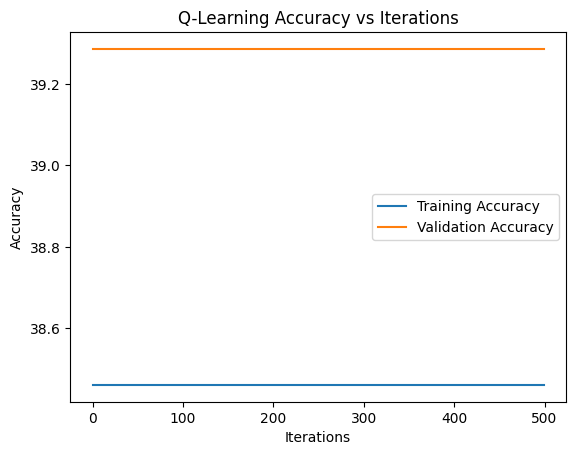

In [39]:
plt.plot(accuracy_list, label='Training Accuracy')
plt.plot(val_accuracy_list, label='Validation Accuracy')
plt.title('Q-Learning Accuracy vs Iterations')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [40]:
q_agent = QLearning(state_shape=(256,256,3), action_size=2)

min_loss = 0.0
min_val_loss = 0.0
num_runs = 500
loss_list = []
val_loss_list = []

q_agent.train(X_train, y_train, epochs=100)

for i in range(num_runs):
     loss = q_agent.get_loss(X_train, y_train)
     if loss < min_loss:
        min_loss = loss
     loss_list.append(loss)
print("Loss:", min_loss)


for i in range(num_runs):
     val_loss = q_agent.get_loss(X_test, y_test)
     if  val_loss < min_val_loss:
        min_val_loss = val_loss
     val_loss_list.append(val_loss)
print(" Validation Loss:", min_val_loss)

Loss: 0.0
 Validation Loss: 0.0


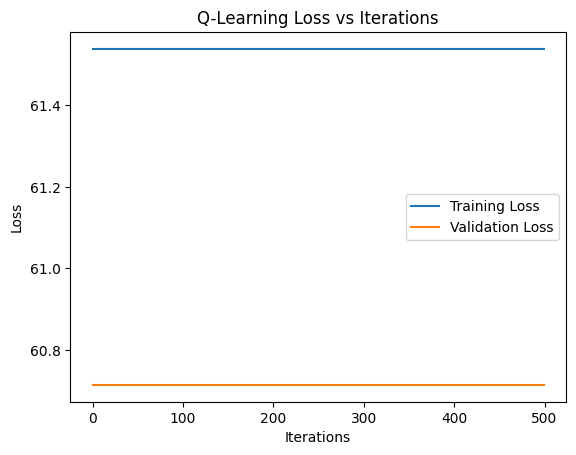

In [41]:
# plot the accuracy vs iterations
plt.plot(loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('Q-Learning Loss vs Iterations')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()